# Exploring Time constants

In [1]:
import os
import tensorflow as tf
import yaml
import numpy as np
import matplotlib.pyplot as plt



In [2]:
# load a model that does okay at estimation
#basedir = '/Users/JRyu/github/det_rnn/experiments/grnn2/test005/'
basedir = '/Users/JRyu/github/det_rnn/experiments/grnn2_test/hptest001'
basedir = '/Users/JRyu/github/det_rnn/experiments/grnn2/hptest001'
model = tf.saved_model.load(os.path.join(basedir, 'model', 'iter101'))

with open(os.path.join(basedir, 'hp.yaml'),'rb') as file:
    hp = yaml.load(file, Loader=yaml.Loader)

hp

{'U': (0.15, 0.45),
 'act': 'sigmoid',
 'alpha_std': (0.05, 0.00667),
 'alpha_stf': (0.00667, 0.05),
 'clip_max_grad_val': 0.1,
 'dale': False,
 'dropout': 0,
 'dt': 10.0,
 'dtype': 'tf.float32',
 'exc_inh_prop': 0.8,
 'gate_out': False,
 'gate_rnn': True,
 'input_rule_rg': {'decision': array([ 800,  801,  802,  803,  804,  805,  806,  807,  808,  809,  810,
          811,  812,  813,  814,  815,  816,  817,  818,  819,  820,  821,
          822,  823,  824,  825,  826,  827,  828,  829,  830,  831,  832,
          833,  834,  835,  836,  837,  838,  839,  840,  841,  842,  843,
          844,  845,  846,  847,  848,  849,  850,  851,  852,  853,  854,
          855,  856,  857,  858,  859,  860,  861,  862,  863,  864,  865,
          866,  867,  868,  869,  870,  871,  872,  873,  874,  875,  876,
          877,  878,  879,  880,  881,  882,  883,  884,  885,  886,  887,
          888,  889,  890,  891,  892,  893,  894,  895,  896,  897,  898,
          899,  900,  901,  902,  903, 

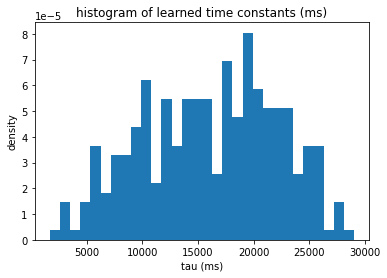

In [3]:
tau_unnorm = model.rnncell.tau_unnorm
tau = tf.sigmoid(tau_unnorm) * (hp['tau_max'] - hp['tau_min']) + hp['tau_min'] 
tau = tau.numpy()
plt.hist(tau, bins = 30,density=True)
plt.title('histogram of learned time constants (ms)')
plt.xlabel('tau (ms)')
plt.ylabel('density')
plt.show()

In [4]:
tau_indices = np.argsort(tau)

In [5]:
# basic checks to see if the matrices are resorted
rnnmat = model.rnncell.rnnmat.numpy()[tau_indices,:]
rnnmat = rnnmat[:,tau_indices]
print(model.rnncell.rnnmat.numpy()[178,236])
print(rnnmat[0,1])
model.rnncell.Wmd_rnn_a.numpy().shape

-1.0162326
0.07190521


(300, 4)

/opt/anaconda3/envs/detrnn37/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


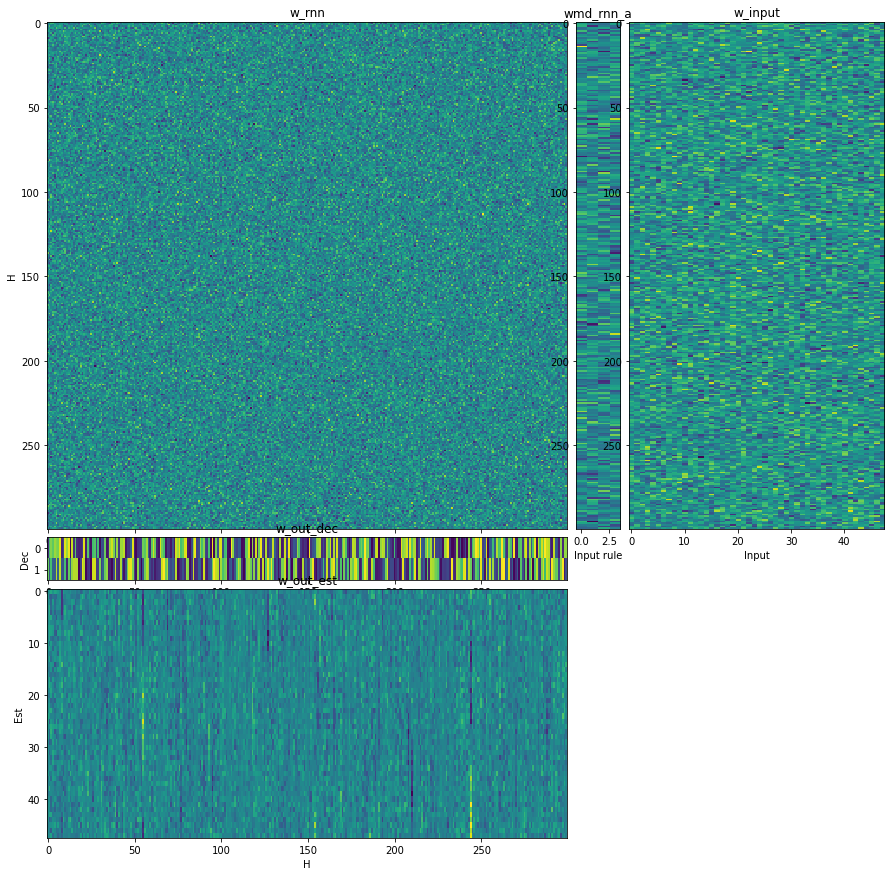

In [15]:
fig = plt.figure(constrained_layout = True, figsize=(15, 15))
ax1 = plt.subplot2grid((16, 16), (0, 0), rowspan=10, colspan=10);
ax1.set_title("w_rnn")
ax1.set_ylabel("H")
ax2 = plt.subplot2grid((16, 16), (0, 10), rowspan=10, colspan=1);
ax2.set_title("wmd_rnn_a")
ax2.set_xlabel("Input rule")
ax3 = plt.subplot2grid((16, 16), (0, 11), rowspan=10, colspan=5);
ax3.set_title("w_input")
ax3.set_xlabel("Input")
ax4 = plt.subplot2grid((16, 16), (10, 0), rowspan=1, colspan=10);
ax4.set_title("w_out_dec")
ax4.set_ylabel("Dec")
ax5 = plt.subplot2grid((16, 16), (11, 0), rowspan=5, colspan=10);
ax5.set_title("w_out_est")
ax5.set_ylabel("Est")
ax5.set_xlabel("H")

allmax = tf.reduce_max([tf.reduce_max(model.rnncell.rnnmat),
    tf.reduce_max(model.rnncell.Win),
    tf.reduce_max(model.rnncell.Wmd_rnn_a),
    tf.reduce_max(model.dec.trainable_variables[0]),
    tf.reduce_max(model.est.trainable_variables[0])])

allmin = tf.reduce_min([tf.reduce_min(model.rnncell.rnnmat),
    tf.reduce_min(model.rnncell.Win),
    tf.reduce_min(model.rnncell.Wmd_rnn_a),
    tf.reduce_min(model.dec.trainable_variables[0]),
    tf.reduce_min(model.est.trainable_variables[0])])

rnnmat = model.rnncell.rnnmat.numpy()[tau_indices,:]
rnnmat = rnnmat[:,tau_indices]
Win = model.rnncell.Win.numpy()[tau_indices,:]
Winrule = model.rnncell.Wmd_rnn_a.numpy()[tau_indices,:]
Wout_est = model.est.trainable_variables[0].numpy().T[:,tau_indices]
Wout_dec = model.dec.trainable_variables[0].numpy().T[:,tau_indices]

im1 = ax1.imshow(rnnmat,
                 interpolation='none',
                 aspect='auto')
im2 = ax2.imshow(Winrule,
                 interpolation='none',
                 aspect='auto')
im3 = ax3.imshow(Win,
                 interpolation='none',
                 aspect='auto')
im4 = ax4.imshow(Wout_dec,
                 interpolation='none',
                 aspect='auto')
im5 = ax5.imshow(Wout_est,
                 interpolation='none',
                 aspect='auto')

# plt.tight_layout()
plt.show()

In [7]:
x = []
y = []
w = []

for i in range(rnnmat.shape[0]):
    for j in range(rnnmat.shape[1]):
        y += [tau[tau_indices[i]]]
        x += [tau[tau_indices[j]]]
        w += [rnnmat[i,j]]
        
x = np.array(x)
y = np.array(y)
w = np.array(w)

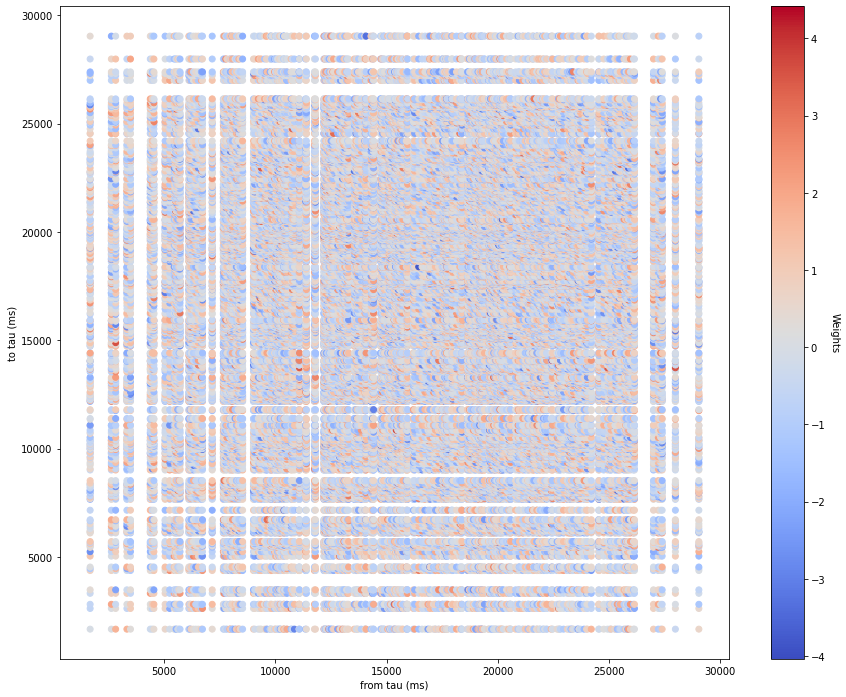

In [8]:
plt.figure(figsize=(15,12))
plt.scatter(x, y, marker='o', c=w, cmap='coolwarm')
plt.xlabel('from tau (ms)')
plt.ylabel('to tau (ms)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Weights', rotation=-90, va="bottom")
plt.show()

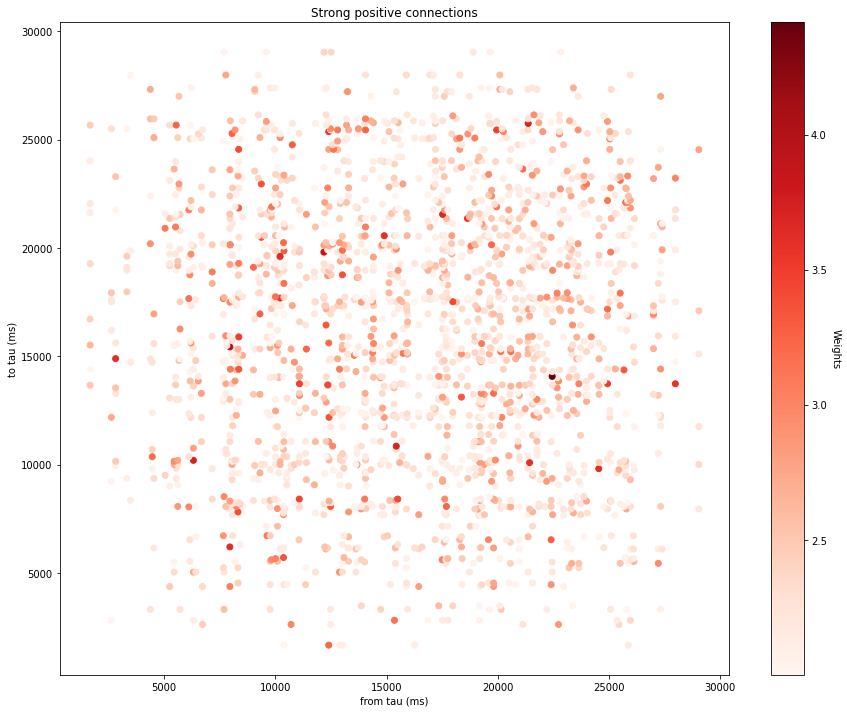

In [9]:
plt.figure(figsize=(15,12))
plt.scatter(x[w>2], y[w>2], marker='o', c=w[w>2], cmap='Reds')
plt.xlabel('from tau (ms)')
plt.ylabel('to tau (ms)')
plt.title('Strong positive connections')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Weights', rotation=-90, va="bottom")
plt.show()

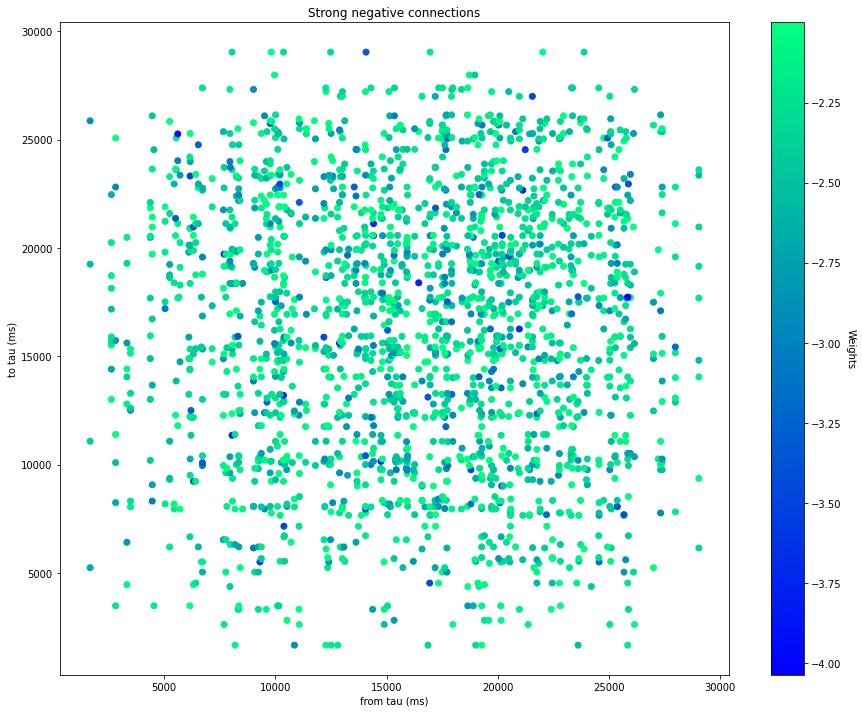

In [10]:
plt.figure(figsize=(15,12))
plt.scatter(x[w<-2], y[w<-2], marker='o', c=w[w<-2], cmap='winter')
plt.xlabel('from tau (ms)')
plt.ylabel('to tau (ms)')
plt.title('Strong negative connections')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Weights', rotation=-90, va="bottom")
plt.show()

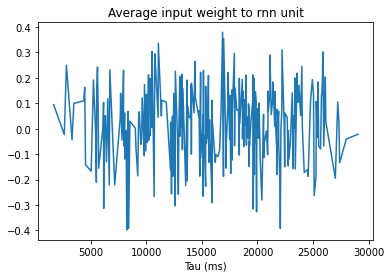

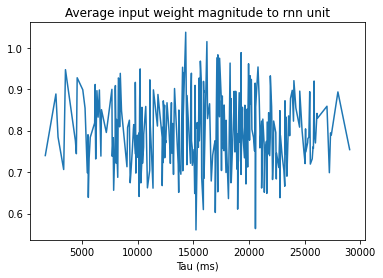

In [13]:
plt.plot(tau[tau_indices], np.mean(Win,axis=-1))
plt.title('Average input weight to rnn unit')
plt.xlabel('Tau (ms)')
plt.show()

plt.plot(tau[tau_indices], np.mean(np.abs(Win),axis=-1))
plt.title('Average input weight magnitude to rnn unit')
plt.xlabel('Tau (ms)')
plt.show()

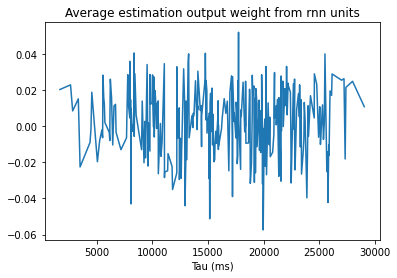

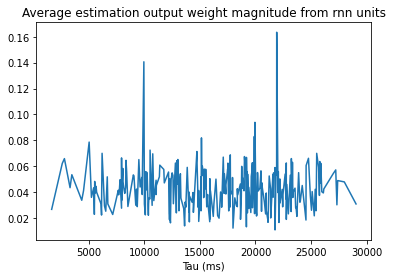

In [17]:
plt.plot(tau[tau_indices], np.mean(Wout_est,axis=0))
plt.title('Average estimation output weight from rnn units')
plt.xlabel('Tau (ms)')
plt.show()

plt.plot(tau[tau_indices], np.mean(np.abs(Wout_est),axis=0))
plt.title('Average estimation output weight magnitude from rnn units')
plt.xlabel('Tau (ms)')
plt.show()

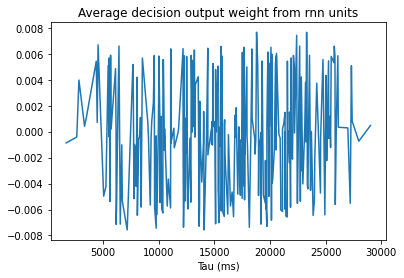

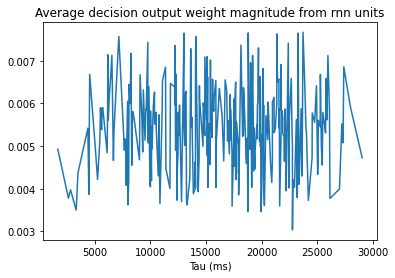

In [18]:
plt.plot(tau[tau_indices], np.mean(Wout_dec,axis=0))
plt.title('Average decision output weight from rnn units')
plt.xlabel('Tau (ms)')
plt.show()

plt.plot(tau[tau_indices], np.mean(np.abs(Wout_dec),axis=0))
plt.title('Average decision output weight magnitude from rnn units')
plt.xlabel('Tau (ms)')
plt.show()

Correlation between estimation and decision weights: 
[[ 1.         -0.08960566]
 [-0.08960566  1.        ]]


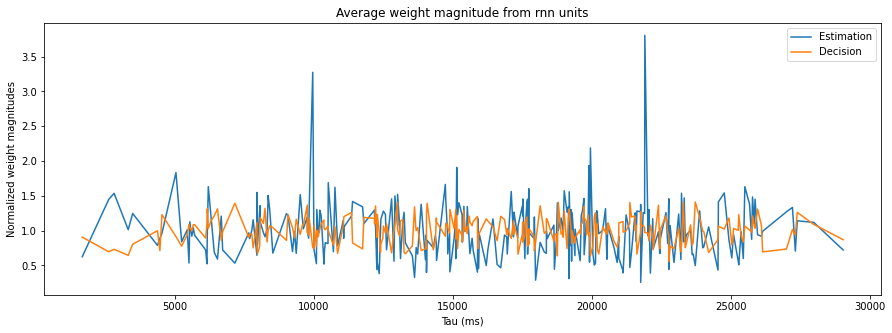

In [29]:
rnntoest = np.mean(np.abs(Wout_est),axis=0)
rnntodec = np.mean(np.abs(Wout_dec),axis=0)

print('Correlation between estimation and decision weights: ')
print(np.corrcoef(rnntoest,rnntodec)) # mild negative correlation between decision and estimation units

plt.figure(figsize=(15,5))
plt.plot(tau[tau_indices], (rnntoest)/np.mean(rnntoest), label = 'Estimation')
plt.plot(tau[tau_indices], (rnntodec)/np.mean(rnntodec), label = 'Decision')
plt.title('Average weight magnitude from rnn units')
plt.legend(['Estimation', 'Decision'])
plt.xlabel('Tau (ms)')
plt.ylabel('Normalized weight magnitudes')
plt.show()

In [36]:
# estimat
estim_units = ((rnntoest > np.mean(rnntoest)) & (rnntodec < np.mean(rnntodec)))
decis_units = ((rnntoest < np.mean(rnntoest)) & (rnntodec > np.mean(rnntodec)))

print(np.sum(estim_units))
print(np.sum(decis_units))
print(len(decis_units))

print('Correlation between estimation and decision weights for selected units: ')
print(np.corrcoef(rnntoest[estim_units | decis_units],rnntodec[estim_units | decis_units])) # mild negative correlation between decision and estimation units

66
80
300
Correlation between estimation and decision weights: 
[[ 1.         -0.58562561]
 [-0.58562561  1.        ]]


In [46]:
estdec_idx = np.concatenate([np.where(estim_units)[0],np.where(decis_units)[0]])

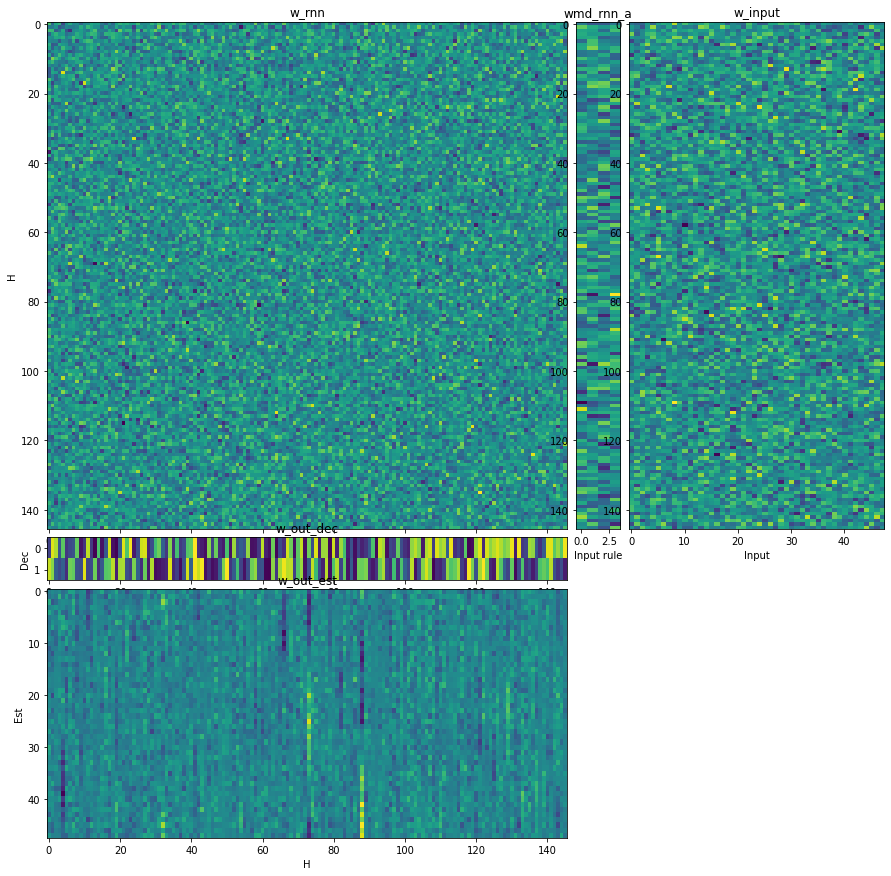

In [48]:
fig = plt.figure(constrained_layout = True, figsize=(15, 15))
ax1 = plt.subplot2grid((16, 16), (0, 0), rowspan=10, colspan=10);
ax1.set_title("w_rnn")
ax1.set_ylabel("H")
ax2 = plt.subplot2grid((16, 16), (0, 10), rowspan=10, colspan=1);
ax2.set_title("wmd_rnn_a")
ax2.set_xlabel("Input rule")
ax3 = plt.subplot2grid((16, 16), (0, 11), rowspan=10, colspan=5);
ax3.set_title("w_input")
ax3.set_xlabel("Input")
ax4 = plt.subplot2grid((16, 16), (10, 0), rowspan=1, colspan=10);
ax4.set_title("w_out_dec")
ax4.set_ylabel("Dec")
ax5 = plt.subplot2grid((16, 16), (11, 0), rowspan=5, colspan=10);
ax5.set_title("w_out_est")
ax5.set_ylabel("Est")
ax5.set_xlabel("H")

allmax = tf.reduce_max([tf.reduce_max(model.rnncell.rnnmat),
    tf.reduce_max(model.rnncell.Win),
    tf.reduce_max(model.rnncell.Wmd_rnn_a),
    tf.reduce_max(model.dec.trainable_variables[0]),
    tf.reduce_max(model.est.trainable_variables[0])])

allmin = tf.reduce_min([tf.reduce_min(model.rnncell.rnnmat),
    tf.reduce_min(model.rnncell.Win),
    tf.reduce_min(model.rnncell.Wmd_rnn_a),
    tf.reduce_min(model.dec.trainable_variables[0]),
    tf.reduce_min(model.est.trainable_variables[0])])

rnnmat = model.rnncell.rnnmat.numpy()[estdec_idx,:]
rnnmat = rnnmat[:,estdec_idx]
Win = model.rnncell.Win.numpy()[estdec_idx,:]
Winrule = model.rnncell.Wmd_rnn_a.numpy()[estdec_idx,:]
Wout_est = model.est.trainable_variables[0].numpy().T[:,estdec_idx]
Wout_dec = model.dec.trainable_variables[0].numpy().T[:,estdec_idx]

im1 = ax1.imshow(rnnmat,
                 interpolation='none',
                 aspect='auto')
im2 = ax2.imshow(Winrule,
                 interpolation='none',
                 aspect='auto')
im3 = ax3.imshow(Win,
                 interpolation='none',
                 aspect='auto')
im4 = ax4.imshow(Wout_dec,
                 interpolation='none',
                 aspect='auto')
im5 = ax5.imshow(Wout_est,
                 interpolation='none',
                 aspect='auto')

# plt.tight_layout()
plt.show()